# Dynamic Memory Networks

## Overview

This notebook goes through the implementation of DMN and DMN+ published by some of the awesome folks at Metamind (now Salesforce). 

#### Goals
* introduce the main concepts and components of model architecture
* implement the model using Pytorch
* test and validate results on bAbI dataset

### Papers & Ressources

** Papers **:
* [Ask Me Anything: Dynamic Memory Networks for Natural Language Processing](https://arxiv.org/abs/1506.07285)
* [Dynamic Memory Networks for Visual and Textual Question Answering](https://arxiv.org/abs/1603.01417)


** DMN in Theano **:
* [github](https://github.com/YerevaNN/Dynamic-memory-networks-in-Theano)
* [blogpost](https://yerevann.github.io/2016/02/05/implementing-dynamic-memory-networks/)

** Talks **:
* [Dynamic Memory Networks for Visual and Textual Question Answering - Stephen Merity (MetaMind)](https://www.youtube.com/watch?v=Qf0BqEk5n3o&t=1145s)

## Model

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn.init as init
from torch.optim import Adam
from torch.utils.data import DataLoader
import shutil
import os

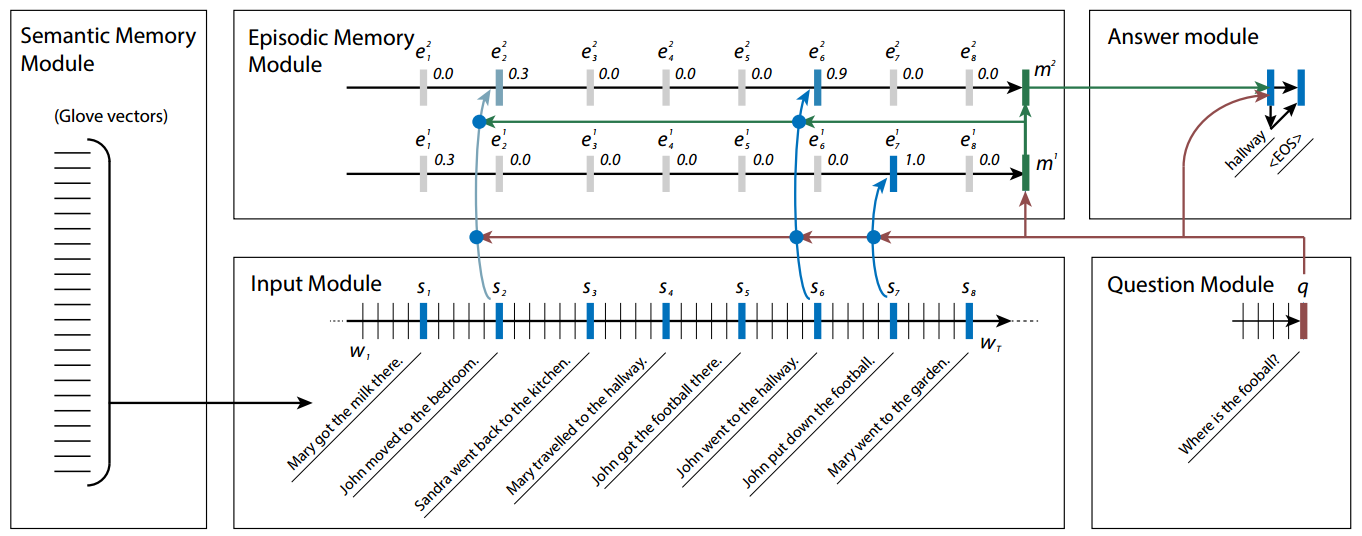

### GloVe (Semantic Memory Module)

In [2]:
glove_path = '/home/mark/data/datasets/nlp/glove/'
glove_res_path = './results/'
glove_name = '6B.50d'

In [3]:
from utils import get_glove, load_glove

In [4]:
get_glove(glove_path, glove_res_path, glove_name)

In [5]:
vecs, words, wordidx = load_glove(glove_res_path+glove_name)

In [6]:
vecs.shape

(400000, 50)

### Input Module

* The input to the module is sequence of $T_I$ words $w_1$,...,$w_T$ given as embeddings to the recurrent network.
* The network processes the input data into a set of vectors termed facts, represented as $F=[f_1,...,f_N]$

#### Original (DMN)

In the original paper, the Input Module was a single GRU network processing all the words and extracting sentence representations by storing the hidden states produced at the end of sentence markers (EOS).

##### GRU:

\begin{array}{ll}
u_i = \mathrm{sigmoid}(W^{(u)} x_i + U^{(u)} h_{i-1} + b^{(u)}) \\
r_i = \mathrm{sigmoid}(W^{(r)} x_i + U^{(r)} h_{i-1} + b^{(r)}) \\
\tilde{h_i} = \tanh(W x_i + r_i \bullet U h_{i-1} + b^{h}) \\
h_i = u_i \bullet \tilde{h_i} + (1-u_i) \bullet h_{i-1} \\
\end{array}

##### Limitations
One large limitation of single GRU is that it only allow sentences to have context from sentences in a previous timesteps, but not from future ones.

#### Improved (DMN+)

The improved version replaces the single GRU with two different components:
* Sentence Reader: encodes the words into sentence embeddings
* Input Fusion Layer: allows for interaction between sentences

To further medigate the limitations of the single GRU, a bi-directional GRU is used in the input fusion layer, since it allows information from both past and future sentences to be utilized.

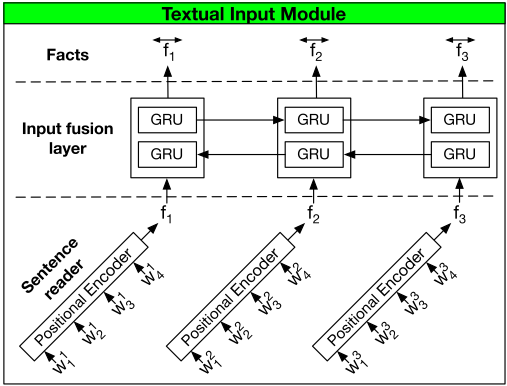

##### Sentence Reader

Uses a **positional encoding** scheme.

Sentence representations is produced by $f_i = \sum_{M}^{j=1} l_j \bullet w_j^i $, where $\bullet$ is element-wise multiplication and $l_j$ is column vector with structure $l_{jd} = (1 - j/M) - (d/D)(1-2j/M)$ where `d` is the embedding index and D is the embedding dimension

In [7]:
def positional_encoding(emb):
    # batch, sentence, tokens, embedding
    _, _, slen, elen = emb.size()
    l = [[(1-s/(slen-1)) - (e/(elen-1)) * (1-2*s/(slen-1)) for e in range(elen)]
         for s in range (slen)]
    l = torch.FloatTensor(l)
    l = l.unsqueeze(0) # batch
    l = l.unsqueeze(1) # sentence
    l = l.expand_as(emb)
    
    w = emb * Variable(l.cuda())
    return torch.sum(w, dim=2).squeeze(2) # sum over tokens

##### Input Fusion Layer

The input fusion layers takes these input facts and enables an information exchange between them by applying a bidirectional GRU.

$$ \overrightarrow{f_i} = GRU_{fwd} (f_i, \overrightarrow{f_{i-1}}) $$
$$ \overleftarrow{f_i} = GRU_{bwd} (f_i, \overleftarrow{f_{i+1}}) $$
$$ \overleftrightarrow{f_i} = \overleftarrow{f_i} + \overrightarrow{f_i} $$

In [8]:
class InputModule(nn.Module):
    def __init__(self, vocab_size, h_size):
        super(InputModule, self).__init__()
        self.h_size = h_size
        self.gru = nn.GRU(h_size, h_size, bidirectional=True, batch_first=True)
        for name, param in self.gru.state_dict().items():
            if 'weight' in name: init.xavier_normal(param)
        self.dropout = nn.Dropout(0.1)
    
    def forward(self, contexts, word_emb):
        n_batches, n_sens, n_tokens = contexts.size()
        
        # contexts embeddings
        c_emb = word_emb(contexts.view(n_batches, -1))
        c_emb = c_emb.view(n_batches, n_sens, n_tokens, -1)
        
        # sentence reader 
        facts = positional_encoding(c_emb)
        facts = self.dropout(facts)
        
        h_0 = Variable(torch.zeros(2, n_batches, self.h_size).cuda()) # initial hidden state
        facts, _ = self.gru(facts, h_0)
        return facts[:, :, :h_size] + facts[:, :, h_size:]

### Question Module

Computes a vector representation of `q` of the question, where `q` is the final state of a GRU over the words in the question

In [9]:
class QuestionModule(nn.Module):
    def __init__(self, vocab_size, h_size):
        super(QuestionModule, self).__init__()
        self.gru = nn.GRU(h_size, h_size, batch_first=True)
    
    def forward(self, questions, word_emb):
        q_emb = word_emb(questions)
        _, questions = self.gru(q_emb)
        return questions.transpose(0, 1)

### Episodic Memory Module

Given a collection of facts, the episodic memory aims to to retrieve the information required to answer the question q. The module uses two distinct mechanisms to accomplish this:
* An attention mechanism (gating function): to determine relevant facts and produce a contextual vector $c^t$
* An memory update mechanism: for generating the episode memory $m^t$

To improve the understanding of both the question and input (facts), especially if questions require ** transitive reasoning**, the episode memory module may pass over the input multiple times, updating episode memory after each pass.

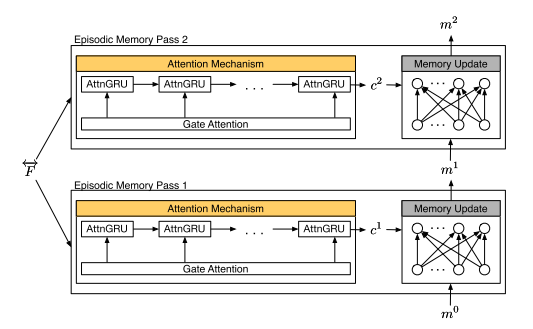

The episodic memory module retrieves information from the input facts $\overleftrightarrow{F} = [\overleftarrow{f_1},...,\overrightarrow{f_N}]$ by focusing on a subset of these facts.

The attention is a single scalar value, the attention gate $g_i^t$ associated with each fact $\overleftrightarrow{f_i}$ during pass $t$.

This is computed by allowing interactions between the fact and both the questiokn representation and the episode memory state:

$$z_i^t = [\overleftrightarrow{f_i} \bullet q; \overleftrightarrow{f_i} \bullet m^{t-1}; | \overleftrightarrow{f_i} - q | ; | \overleftrightarrow{f_i} - m^{t-i}|] $$

$$Z_i^t = W^{(2)} tanh(W^{(1)}z_i^t + b^{(1)}) + b^{(2)} $$

$$g_i^t = \frac{exp(Z_i^t)}{\sum_{k=1}^{M_i} exp(Z_k^t)} $$

#### Attention Mechanism

DMN+ further improves performance by switching from **soft attention** to an **attention-based GRU**
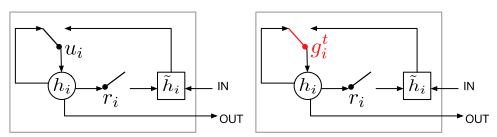

The **attention-based GRU** is simply a modified GRU of the following:

$$g_i^t = \frac{exp(Z_i^t)}{\sum_{k=1}^{M_i} exp(Z_k^t)} $$
$$r_i = \mathrm{sigmoid}(W^{(r)} x_i + U^{(r)} h_{i-1} + b^{(r)}) $$
$$ \tilde{h_i} = \tanh(W x_i + r_i \bullet U h_{i-1} + b^{h}) $$
$$h_i = g_i \bullet \tilde{h_i} + (1-g_i) \bullet h_{i-1} $$


In [10]:
class AttentionGRUCell(nn.Module):
    def __init__(self, inp_size, h_size):
        super(AttentionGRUCell, self).__init__()
        self.h_size = h_size
        self.Wr = nn.Linear(inp_size, h_size)
        init.xavier_normal(self.Wr.state_dict()['weight'])
        self.Ur = nn.Linear(h_size, h_size)
        init.xavier_normal(self.Ur.state_dict()['weight'])
        self.W = nn.Linear(inp_size, h_size)
        init.xavier_normal(self.W.state_dict()['weight'])
        self.U = nn.Linear(inp_size, h_size)
        init.xavier_normal(self.U.state_dict()['weight'])
    
    def forward(self, x, h_prev, g):
        # x: facts
        # h_prev: contextual vector c
        # g: attention gate
        r = F.sigmoid(self.Wr(x) + self.Ur(h_prev))
        h_tilde = F.tanh(self.W(x) + r * self.U(h_prev))
        g = g.unsqueeze(1).expand_as(h_tilde)
        h = g * h_tilde + (1-g) * h_prev
        return h

In [11]:
class AttentionGRU(nn.Module):
    def __init__(self, inp_size, h_size):
        super(AttentionGRU, self).__init__()
        self.h_size = h_size
        self.AttCell = AttentionGRUCell(inp_size, h_size)
    
    def forward(self, x, G):
        # x: facts
        # G: simple two-layer feed forward NN
        n_batches, n_sens, emb_size = x.size()
        C = Variable(torch.zeros(self.h_size)).cuda()
        for sid in range(n_sens):
            fact = x[:, sid, :]
            g = G[:, sid]
            if sid == 0:
                C = C.unsqueeze(0).expand_as(fact)
            C = self.AttCell(fact, C, g)
        return C

#### Memory Update Mechanism

After each pass through the attention mechanism, we want to update the episode memory $m^{t-1}$ with the neewly constructed contextual vector $c^t$, producing $m^t$.

The paper experiments with different memory updated, both using an **tied-model** and an **untied model**:


$$m^t = GRU(c^t, m^{t-1})$$

$$m^t = ReLU(W^t[m^{t-1};c^t;q]+b)$$

The best results a are achieved using the untied-model.


In [12]:
class EpisodicMemoryModule(nn.Module):
    def __init__(self, h_size):
        super(EpisodicMemoryModule, self).__init__()
        self.AttGRU = AttentionGRU(h_size, h_size)
        self.z1 = nn.Linear(4 * h_size, h_size)
        init.xavier_normal(self.z1.state_dict()['weight'])
        self.z2 = nn.Linear(h_size, 1)
        init.xavier_normal(self.z2.state_dict()['weight'])
        self.m_next = nn.Linear(3 * h_size, h_size)
        init.xavier_normal(self.m_next.state_dict()['weight'])
            
    def interact(self, f, q, m_prev):
        '''
            f: facts
            q: questions
            m_prev: previous memory
        '''
        n_batches, n_sen, emb_size = f.size()
        q = q.expand_as(f)
        m_prev = m_prev.expand_as(f)
        
        z = torch.cat([
            f * q,
            f * m_prev,
            torch.abs(f - q),
            torch.abs(f - m_prev)
        ], dim=2)
        
        z = z.view(-1, 4 * emb_size)
        Z = self.z2(F.tanh(self.z1(z)))
        g = F.softmax(Z.view(n_batches, -1))
        return g
    
    def forward(self, f, q, m_prev):
        g = self.interact(f, q, m_prev)
        c = self.AttGRU(f, g)
        # memory update
        m_next = F.relu(self.m_next(
            torch.cat([m_prev.squeeze(1), c, q.squeeze(1)], dim=1)))
        m_next = m_next.unsqueeze(1)
        return m_next

### Answer Module

The answer module receives both $q$ and $m^T$ to generate the model's predicted answer.
* For simple answers (single word) a linear layer with softmax activation is used
* For answers requiring a sequence output, an RNN may be used to decode $a = [q;m^T]$ to an ordered set of tokens.

In [13]:
class AnswerModule(nn.Module):
    def __init__(self,vocab_size, h_size):
        super(AnswerModule, self).__init__()
        self.linear = nn.Linear(2*h_size, vocab_size)
        # init xavier
        self.dropout = nn.Dropout(0.1)
    
    def forward(self, q, m):
        m = self.dropout(m)
        a = self.linear(torch.cat([m, q], dim=2).squeeze(1))
        return a

### DMN+

In [14]:
class DMNPlus(nn.Module):
    def __init__(self, vocab_size, h_size, n_hops=3):
        super(DMNPlus, self).__init__()
        self.n_hops = n_hops
        self.word_emb = nn.Embedding(vocab_size, h_size, padding_idx=0, sparse=True).cuda()
        init.uniform(self.word_emb.state_dict()['weight'], a=-(3**0.5), b=3**0.5)
        self.loss_fn = nn.CrossEntropyLoss(size_average=False)
        self.input_module = InputModule(vocab_size, h_size)
        self.question_module = QuestionModule(vocab_size, h_size)
        self.ememory_module = EpisodicMemoryModule(h_size)
        self.answer_module = AnswerModule(vocab_size, h_size)
    
    def forward(self, contexts, questions):
        f = self.input_module(contexts, self.word_emb)
        q = self.question_module(questions, self.word_emb)
        # initialize memory with q
        m = q
        for hop in range(self.n_hops):
            m = self.ememory_module(f, q, m)
        a = self.answer_module(m, q)
        return a
    
    def get_loss(self, contexts, questions, answers):
        out = self.forward(contexts, questions)
        loss = self.loss_fn(out, answers)
        
        reg_loss = 0
        for param in self.parameters():
            reg_loss += 0.001 * torch.sum(param * param)
        preds = F.softmax(out)
        _, pred_ids = torch.max(preds, dim=1)
        corrects = (pred_ids.data == answers.data)
        acc = torch.mean(corrects.float())
        return loss+reg_loss, acc

## Train and test (bAbI)

In [15]:
from babi_data import BabiDataset, pad_collate

In [16]:
babi_path = '/home/mark/data/datasets/nlp/babi/tasks_1-20_v1-2/en-10k/'

### Hyperparameters
* Adam optimizer with learning rate of 0.001
* batch size of 128
* 256 epochs with early stopping (no improvements in val_loss for 20 epochs)
* xavier initialization for all weights except word embeddings (random uniform $[-\sqrt3, \sqrt3]$)
* both embedding and hidden dimensions of d=80
* l2 regularization on all weights except bias
* dropout on the initial sentence encodings and answer module (p=0.9)
* last 10% of training data for validation
* 3 passes/ hops on all tasks (episodic memory module)

In [17]:
# learning rate w/ Adam optimizer
lr = 0.001
# batch size
batch_size = 128
# epochs with early stopping (val_loss not improved within last 20 epochs)
epochs = 256
# num hidden dimensions
h_size = 80
n_hops=3

In [18]:
def save_checkpoint(state, fname='checkpoint.pth.tar'):
    torch.save(state, fname)
    shutil.copyfile(fname, './models/dmn_best.pth.tar')

In [20]:
for run in range(1):
    # train on all 20 babi tasks
    for task_id in range(1, 21):
        dset = BabiDataset(babi_path, task_id)
        vocab_size = len(dset.vocab)
        
        model = DMNPlus(vocab_size, h_size, n_hops)
        model.cuda()
        # early stopping
        estop_count, estop_flag = 0, False
        best_acc = 0
        optim = Adam(model.parameters())
        
        for epoch in range(epochs):
            train_loader = DataLoader(dset,
                                      batch_size=batch_size,
                                      shuffle=True,
                                      collate_fn=pad_collate)
            model.train()
            if not estop_flag:
                total_acc, cnt = 0, 0
                for batch_idx, data in enumerate(train_loader):
                    optim.zero_grad()
                    contexts, questions, answers = data
                    contexts = Variable(contexts.long().cuda())
                    questions = Variable(questions.long().cuda())
                    answers = Variable(answers.cuda())
                    batch_size = contexts.size()[0]
                    
                    loss, acc = model.get_loss(contexts, questions, answers)
                    loss.backward()
                    
                    total_acc += acc*batch_size
                    cnt += batch_size
                    
                    if batch_idx % 20 == 0:
                        print(f'[Task {task_id}, Epoch {epoch}] [Training] loss : {loss.data[0]: {10}.{8}}, acc : {total_acc / cnt: {5}.{4}}, batch_idx : {batch_idx}')
                    optim.step()
                
                dset.set_mode('valid')
                valid_loader = DataLoader(dset,
                                         batch_size=batch_size,
                                         collate_fn=pad_collate)
                model.eval()
                total_acc, cnt = 0, 0
                for batch_idx, data in enumerate(valid_loader):
                    contexts, questions, answers = data
                    contexts = Variable(contexts.long().cuda())
                    questions = Variable(questions.long().cuda())
                    answers = Variable(answers.cuda())
                    batch_size = contexts.size()[0]
                    
                    _, acc = model.get_loss(contexts, questions, answers)
                    total_acc += acc*batch_size
                    cnt += batch_size
                    
                total_acc = total_acc / cnt
                if total_acc > best_acc:
                    best_acc = total_acc
                    save_checkpoint({
                        'epoch': epoch + 1,
                        'state_dict': model.state_dict(),
                        'best_acc': best_acc,
                        'optimizer': optim.state_dict()
                    })
                    best_state = model.state_dict()
                    estop_count = 0
                else:
                    estop_count += 1
                    if estop_count > 20:
                        estop_flag = True
                
                print(f'[Run {run}, Task {task_id}, Epoch {epoch}] [Validate] Accuracy : {total_acc: {5}.{4}}')
                with open('./results/dmn_log.txt', 'a') as fp:
                    fp.write(f'[Run {run}, Task {task_id}, Epoch {epoch}] [Validate] Accuracy : {total_acc: {5}.{4}}' + '\n')
                if total_acc == 1.0:
                    break
            else:
                print(f'[Run {run}, Task {task_id}] Early Stopping at Epoch {epoch}, Valid Accuracy : {best_acc: {5}.{4}}')
                break
                
        dset.set_mode('test')
        test_loader = DataLoader(dset, batch_size=batch_size, collate_fn=pad_collate)
        test_acc, cnt = 0, 0
        for batch_idx, data in enumerate(test_loader):
            contexts, questions, answers = data
            contexts = Variable(contexts.long().cuda())
            questions = Variable(questions.long().cuda())
            answers = Variable(answers.cuda())
            batch_size = contexts.size()[0]
            
            model.load_state_dict(best_state)
            _, acc = model.get_loss(contexts, questions, answers)
            test_acc += acc * batch_size
            cnt += batch_size
        print(f'[Run {run}, Task {task_id}, Epoch {epoch}] [Test] Accuracy : {test_acc / cnt: {5}.{4}}')
        with open(f'models/dmn_task{task_id}_epoch{epoch}_run{run}_acc{test_acc/cnt}.pth', 'wb') as fp:
            torch.save(model.state_dict(), fp)
        with open('./results/dmn_log.txt', 'a') as fp:
            fp.write(f'[Run {run}, Task {task_id}, Epoch {epoch}] [Test] Accuracy : {total_acc: {5}.{4}}' + '\n')

[Task 1, Epoch 0] [Training] loss :  123.85045, acc :   0.0, batch_idx : 0
[Task 1, Epoch 0] [Training] loss :  80.025452, acc :  0.1857, batch_idx : 20
[Task 1, Epoch 0] [Training] loss :  76.197998, acc :  0.1787, batch_idx : 40
[Task 1, Epoch 0] [Training] loss :  75.469002, acc :  0.182, batch_idx : 60
[Task 1, Epoch 0] [Training] loss :  75.582596, acc :  0.188, batch_idx : 80
[Task 1, Epoch 0] [Training] loss :  72.776993, acc :  0.2054, batch_idx : 100
[Task 1, Epoch 0] [Training] loss :  66.649902, acc :  0.238, batch_idx : 120
[Task 1, Epoch 0] [Training] loss :  58.318638, acc :  0.2748, batch_idx : 140
[Task 1, Epoch 0] [Training] loss :  58.906448, acc :  0.3012, batch_idx : 160
[Task 1, Epoch 0] [Training] loss :  62.080315, acc :  0.321, batch_idx : 180
[Task 1, Epoch 0] [Training] loss :  61.109886, acc :  0.3456, batch_idx : 200
[Task 1, Epoch 0] [Training] loss :  53.957199, acc :  0.3585, batch_idx : 220
[Run 0, Task 1, Epoch 0] [Validate] Accuracy :  0.534
[Task 1, E

[Run 0, Task 2, Epoch 19] [Validate] Accuracy :  0.89
[Task 2, Epoch 20] [Training] loss :   19.30901, acc :  0.825, batch_idx : 0
[Task 2, Epoch 20] [Training] loss :   34.75235, acc :  0.8357, batch_idx : 20
[Run 0, Task 2, Epoch 20] [Validate] Accuracy :  0.88
[Task 2, Epoch 21] [Training] loss :  19.362217, acc :  0.875, batch_idx : 0
[Task 2, Epoch 21] [Training] loss :  21.813042, acc :  0.8452, batch_idx : 20
[Run 0, Task 2, Epoch 21] [Validate] Accuracy :  0.937
[Task 2, Epoch 22] [Training] loss :  13.886886, acc :   0.9, batch_idx : 0
[Task 2, Epoch 22] [Training] loss :  17.707796, acc :  0.8964, batch_idx : 20
[Run 0, Task 2, Epoch 22] [Validate] Accuracy :  0.955
[Task 2, Epoch 23] [Training] loss :  11.130507, acc :  0.95, batch_idx : 0
[Task 2, Epoch 23] [Training] loss :  21.006268, acc :  0.8869, batch_idx : 20
[Run 0, Task 2, Epoch 23] [Validate] Accuracy :  0.957
[Task 2, Epoch 24] [Training] loss :   11.85553, acc :  0.95, batch_idx : 0
[Task 2, Epoch 24] [Training]

[Task 3, Epoch 13] [Training] loss :  61.415401, acc :  0.35, batch_idx : 0
[Task 3, Epoch 13] [Training] loss :  62.010136, acc :  0.3833, batch_idx : 20
[Run 0, Task 3, Epoch 13] [Validate] Accuracy :  0.433
[Task 3, Epoch 14] [Training] loss :  56.831104, acc :  0.425, batch_idx : 0
[Task 3, Epoch 14] [Training] loss :  57.842297, acc :  0.4155, batch_idx : 20
[Run 0, Task 3, Epoch 14] [Validate] Accuracy :  0.408
[Task 3, Epoch 15] [Training] loss :  61.394489, acc :  0.375, batch_idx : 0
[Task 3, Epoch 15] [Training] loss :  52.700977, acc :  0.4238, batch_idx : 20
[Run 0, Task 3, Epoch 15] [Validate] Accuracy :  0.456
[Task 3, Epoch 16] [Training] loss :   55.22617, acc :  0.475, batch_idx : 0
[Task 3, Epoch 16] [Training] loss :  55.128845, acc :  0.4536, batch_idx : 20
[Run 0, Task 3, Epoch 16] [Validate] Accuracy :  0.528
[Task 3, Epoch 17] [Training] loss :   51.30513, acc :   0.5, batch_idx : 0
[Task 3, Epoch 17] [Training] loss :  51.218956, acc :  0.5024, batch_idx : 20
[R

[Task 3, Epoch 52] [Training] loss :  7.8535919, acc :  0.95, batch_idx : 0
[Task 3, Epoch 52] [Training] loss :  5.8387613, acc :  0.9643, batch_idx : 20
[Run 0, Task 3, Epoch 52] [Validate] Accuracy :  0.978
[Task 3, Epoch 53] [Training] loss :  8.6108761, acc :   0.9, batch_idx : 0
[Task 3, Epoch 53] [Training] loss :  3.3504238, acc :  0.975, batch_idx : 20
[Run 0, Task 3, Epoch 53] [Validate] Accuracy :  0.998
[Task 3, Epoch 54] [Training] loss :  3.7338884, acc :   1.0, batch_idx : 0
[Task 3, Epoch 54] [Training] loss :  5.2558975, acc :  0.9929, batch_idx : 20
[Run 0, Task 3, Epoch 54] [Validate] Accuracy :  0.999
[Task 3, Epoch 55] [Training] loss :  3.8556135, acc :   1.0, batch_idx : 0
[Task 3, Epoch 55] [Training] loss :  3.3145154, acc :  0.9845, batch_idx : 20
[Run 0, Task 3, Epoch 55] [Validate] Accuracy :   1.0
[Run 0, Task 3, Epoch 55] [Test] Accuracy :  0.299
[Task 4, Epoch 0] [Training] loss :   118.0593, acc :  0.05, batch_idx : 0
[Task 4, Epoch 0] [Training] loss : 

[Task 5, Epoch 20] [Training] loss :  5.1735554, acc :  0.9786, batch_idx : 20
[Run 0, Task 5, Epoch 20] [Validate] Accuracy :  0.983
[Task 5, Epoch 21] [Training] loss :  4.4824576, acc :   1.0, batch_idx : 0
[Task 5, Epoch 21] [Training] loss :  8.0029755, acc :  0.9821, batch_idx : 20
[Run 0, Task 5, Epoch 21] [Validate] Accuracy :  0.977
[Task 5, Epoch 22] [Training] loss :  6.5164571, acc :  0.975, batch_idx : 0
[Task 5, Epoch 22] [Training] loss :  4.3995781, acc :  0.9774, batch_idx : 20
[Run 0, Task 5, Epoch 22] [Validate] Accuracy :  0.995
[Task 5, Epoch 23] [Training] loss :  4.1565409, acc :   1.0, batch_idx : 0
[Task 5, Epoch 23] [Training] loss :  8.9759598, acc :  0.9738, batch_idx : 20
[Run 0, Task 5, Epoch 23] [Validate] Accuracy :  0.994
[Task 5, Epoch 24] [Training] loss :  4.1062808, acc :   1.0, batch_idx : 0
[Task 5, Epoch 24] [Training] loss :  4.6070685, acc :  0.9869, batch_idx : 20
[Run 0, Task 5, Epoch 24] [Validate] Accuracy :  0.997
[Task 5, Epoch 25] [Train

[Run 0, Task 6, Epoch 27] [Validate] Accuracy :  0.745
[Task 6, Epoch 28] [Training] loss :  23.270256, acc :  0.775, batch_idx : 0
[Task 6, Epoch 28] [Training] loss :  25.136711, acc :  0.7869, batch_idx : 20
[Run 0, Task 6, Epoch 28] [Validate] Accuracy :  0.826
[Task 6, Epoch 29] [Training] loss :  21.666384, acc :   0.8, batch_idx : 0
[Task 6, Epoch 29] [Training] loss :  22.222233, acc :  0.7726, batch_idx : 20
[Run 0, Task 6, Epoch 29] [Validate] Accuracy :  0.861
[Task 6, Epoch 30] [Training] loss :  19.631107, acc :  0.775, batch_idx : 0
[Task 6, Epoch 30] [Training] loss :    21.0254, acc :  0.8024, batch_idx : 20
[Run 0, Task 6, Epoch 30] [Validate] Accuracy :  0.866
[Task 6, Epoch 31] [Training] loss :  20.764709, acc :  0.85, batch_idx : 0
[Task 6, Epoch 31] [Training] loss :  25.811176, acc :  0.8405, batch_idx : 20
[Run 0, Task 6, Epoch 31] [Validate] Accuracy :  0.889
[Task 6, Epoch 32] [Training] loss :  18.602699, acc :  0.825, batch_idx : 0
[Task 6, Epoch 32] [Traini

[Task 7, Epoch 7] [Training] loss :  18.983231, acc :  0.825, batch_idx : 0
[Task 7, Epoch 7] [Training] loss :  25.314907, acc :  0.856, batch_idx : 20
[Run 0, Task 7, Epoch 7] [Validate] Accuracy :  0.838
[Task 7, Epoch 8] [Training] loss :  21.217577, acc :  0.85, batch_idx : 0
[Task 7, Epoch 8] [Training] loss :  17.891972, acc :  0.8452, batch_idx : 20
[Run 0, Task 7, Epoch 8] [Validate] Accuracy :  0.86
[Task 7, Epoch 9] [Training] loss :  16.790934, acc :   0.9, batch_idx : 0
[Task 7, Epoch 9] [Training] loss :  17.999296, acc :  0.8476, batch_idx : 20
[Run 0, Task 7, Epoch 9] [Validate] Accuracy :  0.867
[Task 7, Epoch 10] [Training] loss :  25.902599, acc :  0.775, batch_idx : 0
[Task 7, Epoch 10] [Training] loss :  30.552959, acc :  0.8536, batch_idx : 20
[Run 0, Task 7, Epoch 10] [Validate] Accuracy :  0.871
[Task 7, Epoch 11] [Training] loss :  15.028644, acc :   0.9, batch_idx : 0
[Task 7, Epoch 11] [Training] loss :  20.379984, acc :  0.8595, batch_idx : 20
[Run 0, Task 7

[Task 7, Epoch 46] [Training] loss :  4.3204212, acc :  0.9964, batch_idx : 20
[Run 0, Task 7, Epoch 46] [Validate] Accuracy :  0.997
[Task 7, Epoch 47] [Training] loss :   3.646055, acc :   1.0, batch_idx : 0
[Task 7, Epoch 47] [Training] loss :  10.273745, acc :  0.9893, batch_idx : 20
[Run 0, Task 7, Epoch 47] [Validate] Accuracy :  0.991
[Task 7, Epoch 48] [Training] loss :  3.7330372, acc :   1.0, batch_idx : 0
[Task 7, Epoch 48] [Training] loss :  3.6485486, acc :  0.9798, batch_idx : 20
[Run 0, Task 7, Epoch 48] [Validate] Accuracy :  0.991
[Task 7, Epoch 49] [Training] loss :  10.904144, acc :  0.975, batch_idx : 0
[Task 7, Epoch 49] [Training] loss :  3.5978329, acc :  0.9881, batch_idx : 20
[Run 0, Task 7, Epoch 49] [Validate] Accuracy :  0.991
[Task 7, Epoch 50] [Training] loss :  7.1433468, acc :  0.95, batch_idx : 0
[Task 7, Epoch 50] [Training] loss :  3.6768422, acc :  0.9917, batch_idx : 20
[Run 0, Task 7, Epoch 50] [Validate] Accuracy :  0.994
[Task 7, Epoch 51] [Train

[Run 0, Task 8, Epoch 25] [Validate] Accuracy :  0.987
[Task 8, Epoch 26] [Training] loss :   9.017149, acc :  0.925, batch_idx : 0
[Task 8, Epoch 26] [Training] loss :  9.8449984, acc :  0.9762, batch_idx : 20
[Run 0, Task 8, Epoch 26] [Validate] Accuracy :  0.993
[Task 8, Epoch 27] [Training] loss :  5.7075958, acc :   1.0, batch_idx : 0
[Task 8, Epoch 27] [Training] loss :  7.8893948, acc :  0.9786, batch_idx : 20
[Run 0, Task 8, Epoch 27] [Validate] Accuracy :  0.988
[Task 8, Epoch 28] [Training] loss :  4.3729181, acc :   1.0, batch_idx : 0
[Task 8, Epoch 28] [Training] loss :   7.646121, acc :  0.9762, batch_idx : 20
[Run 0, Task 8, Epoch 28] [Validate] Accuracy :  0.988
[Task 8, Epoch 29] [Training] loss :  7.0687237, acc :  0.95, batch_idx : 0
[Task 8, Epoch 29] [Training] loss :  12.494178, acc :  0.9702, batch_idx : 20
[Run 0, Task 8, Epoch 29] [Validate] Accuracy :  0.98
[Task 8, Epoch 30] [Training] loss :  7.7910156, acc :  0.95, batch_idx : 0
[Task 8, Epoch 30] [Training]

[Run 0, Task 9, Epoch 0] [Validate] Accuracy :  0.641
[Task 9, Epoch 1] [Training] loss :  29.890451, acc :  0.625, batch_idx : 0
[Task 9, Epoch 1] [Training] loss :  28.204399, acc :  0.6298, batch_idx : 20
[Run 0, Task 9, Epoch 1] [Validate] Accuracy :  0.641
[Task 9, Epoch 2] [Training] loss :  27.956408, acc :  0.65, batch_idx : 0
[Task 9, Epoch 2] [Training] loss :  26.428747, acc :  0.6369, batch_idx : 20
[Run 0, Task 9, Epoch 2] [Validate] Accuracy :  0.635
[Task 9, Epoch 3] [Training] loss :  28.032324, acc :  0.625, batch_idx : 0
[Task 9, Epoch 3] [Training] loss :  28.831469, acc :  0.6143, batch_idx : 20
[Run 0, Task 9, Epoch 3] [Validate] Accuracy :  0.641
[Task 9, Epoch 4] [Training] loss :  25.597334, acc :  0.675, batch_idx : 0
[Task 9, Epoch 4] [Training] loss :  26.610853, acc :  0.6631, batch_idx : 20
[Run 0, Task 9, Epoch 4] [Validate] Accuracy :  0.643
[Task 9, Epoch 5] [Training] loss :  25.167019, acc :  0.775, batch_idx : 0
[Task 9, Epoch 5] [Training] loss :  28

[Task 9, Epoch 40] [Training] loss :  3.0309322, acc :  0.9905, batch_idx : 20
[Run 0, Task 9, Epoch 40] [Validate] Accuracy :   1.0
[Run 0, Task 9, Epoch 40] [Test] Accuracy :  0.705
[Task 10, Epoch 0] [Training] loss :  130.38484, acc :  0.175, batch_idx : 0
[Task 10, Epoch 0] [Training] loss :  46.900032, acc :  0.4393, batch_idx : 20
[Task 10, Epoch 0] [Training] loss :   41.66745, acc :  0.4451, batch_idx : 40
[Task 10, Epoch 0] [Training] loss :  43.330299, acc :  0.4533, batch_idx : 60
[Task 10, Epoch 0] [Training] loss :  45.069393, acc :  0.4648, batch_idx : 80
[Task 10, Epoch 0] [Training] loss :  41.894943, acc :  0.4671, batch_idx : 100
[Task 10, Epoch 0] [Training] loss :  37.117313, acc :  0.4713, batch_idx : 120
[Task 10, Epoch 0] [Training] loss :  38.111103, acc :  0.4684, batch_idx : 140
[Task 10, Epoch 0] [Training] loss :  42.824043, acc :  0.4661, batch_idx : 160
[Task 10, Epoch 0] [Training] loss :  39.387394, acc :  0.4693, batch_idx : 180
[Task 10, Epoch 0] [Tra

[Task 10, Epoch 34] [Training] loss :  5.1129937, acc :  0.9762, batch_idx : 20
[Run 0, Task 10, Epoch 34] [Validate] Accuracy :  0.983
[Task 10, Epoch 35] [Training] loss :  6.4244342, acc :  0.95, batch_idx : 0
[Task 10, Epoch 35] [Training] loss :   5.442934, acc :  0.969, batch_idx : 20
[Run 0, Task 10, Epoch 35] [Validate] Accuracy :  0.989
[Task 10, Epoch 36] [Training] loss :  14.034773, acc :  0.95, batch_idx : 0
[Task 10, Epoch 36] [Training] loss :  4.8697076, acc :  0.9738, batch_idx : 20
[Run 0, Task 10, Epoch 36] [Validate] Accuracy :  0.993
[Task 10, Epoch 37] [Training] loss :  9.3088112, acc :  0.95, batch_idx : 0
[Task 10, Epoch 37] [Training] loss :  3.9836328, acc :  0.9762, batch_idx : 20
[Run 0, Task 10, Epoch 37] [Validate] Accuracy :  0.987
[Task 10, Epoch 38] [Training] loss :  8.6880531, acc :  0.975, batch_idx : 0
[Task 10, Epoch 38] [Training] loss :  3.8313658, acc :  0.9762, batch_idx : 20
[Run 0, Task 10, Epoch 38] [Validate] Accuracy :  0.989
[Task 10, Ep

[Task 13, Epoch 3] [Training] loss :   10.98104, acc :  0.9512, batch_idx : 20
[Run 0, Task 13, Epoch 3] [Validate] Accuracy :  0.951
[Task 13, Epoch 4] [Training] loss :  17.911709, acc :  0.925, batch_idx : 0
[Task 13, Epoch 4] [Training] loss :  16.304873, acc :  0.9476, batch_idx : 20
[Run 0, Task 13, Epoch 4] [Validate] Accuracy :  0.952
[Task 13, Epoch 5] [Training] loss :  8.2517147, acc :  0.975, batch_idx : 0
[Task 13, Epoch 5] [Training] loss :  8.3763981, acc :  0.9464, batch_idx : 20
[Run 0, Task 13, Epoch 5] [Validate] Accuracy :  0.953
[Task 13, Epoch 6] [Training] loss :  10.526627, acc :  0.925, batch_idx : 0
[Task 13, Epoch 6] [Training] loss :  14.331227, acc :  0.9476, batch_idx : 20
[Run 0, Task 13, Epoch 6] [Validate] Accuracy :  0.955
[Task 13, Epoch 7] [Training] loss :  12.961583, acc :  0.925, batch_idx : 0
[Task 13, Epoch 7] [Training] loss :  7.5226021, acc :  0.9571, batch_idx : 20
[Run 0, Task 13, Epoch 7] [Validate] Accuracy :  0.959
[Task 13, Epoch 8] [Tr

[Task 14, Epoch 12] [Training] loss :  11.271254, acc :  0.9179, batch_idx : 20
[Run 0, Task 14, Epoch 12] [Validate] Accuracy :  0.977
[Task 14, Epoch 13] [Training] loss :  6.8677611, acc :  0.95, batch_idx : 0
[Task 14, Epoch 13] [Training] loss :  17.796999, acc :  0.9369, batch_idx : 20
[Run 0, Task 14, Epoch 13] [Validate] Accuracy :  0.976
[Task 14, Epoch 14] [Training] loss :  7.9508767, acc :  0.95, batch_idx : 0
[Task 14, Epoch 14] [Training] loss :  5.7761974, acc :  0.9464, batch_idx : 20
[Run 0, Task 14, Epoch 14] [Validate] Accuracy :  0.979
[Task 14, Epoch 15] [Training] loss :  4.7271729, acc :   1.0, batch_idx : 0
[Task 14, Epoch 15] [Training] loss :   6.043756, acc :  0.956, batch_idx : 20
[Run 0, Task 14, Epoch 15] [Validate] Accuracy :  0.993
[Task 14, Epoch 16] [Training] loss :  7.0454116, acc :  0.975, batch_idx : 0
[Task 14, Epoch 16] [Training] loss :  16.874855, acc :  0.956, batch_idx : 20
[Run 0, Task 14, Epoch 16] [Validate] Accuracy :  0.982
[Task 14, Epo

[Task 15, Epoch 23] [Training] loss :  7.8034673, acc :   0.9, batch_idx : 20
[Run 0, Task 15, Epoch 23] [Validate] Accuracy :  0.951
[Task 15, Epoch 24] [Training] loss :  13.290009, acc :   0.9, batch_idx : 0
[Task 15, Epoch 24] [Training] loss :   13.93049, acc :  0.9417, batch_idx : 20
[Run 0, Task 15, Epoch 24] [Validate] Accuracy :  0.954
[Task 15, Epoch 25] [Training] loss :  8.6345596, acc :  0.95, batch_idx : 0
[Task 15, Epoch 25] [Training] loss :  4.8664427, acc :  0.9429, batch_idx : 20
[Run 0, Task 15, Epoch 25] [Validate] Accuracy :  0.98
[Task 15, Epoch 26] [Training] loss :  8.7393789, acc :  0.95, batch_idx : 0
[Task 15, Epoch 26] [Training] loss :  7.2556233, acc :  0.9476, batch_idx : 20
[Run 0, Task 15, Epoch 26] [Validate] Accuracy :  0.973
[Task 15, Epoch 27] [Training] loss :  7.1260834, acc :  0.975, batch_idx : 0
[Task 15, Epoch 27] [Training] loss :  8.7571268, acc :  0.9321, batch_idx : 20
[Run 0, Task 15, Epoch 27] [Validate] Accuracy :  0.953
[Task 15, Epoc

[Task 16, Epoch 14] [Training] loss :  30.469156, acc :  0.7131, batch_idx : 20
[Run 0, Task 16, Epoch 14] [Validate] Accuracy :  0.75
[Task 16, Epoch 15] [Training] loss :  24.927797, acc :  0.775, batch_idx : 0
[Task 16, Epoch 15] [Training] loss :  26.129375, acc :  0.7333, batch_idx : 20
[Run 0, Task 16, Epoch 15] [Validate] Accuracy :  0.801
[Task 16, Epoch 16] [Training] loss :  18.945953, acc :  0.85, batch_idx : 0
[Task 16, Epoch 16] [Training] loss :  21.593325, acc :  0.781, batch_idx : 20
[Run 0, Task 16, Epoch 16] [Validate] Accuracy :  0.865
[Task 16, Epoch 17] [Training] loss :  16.154594, acc :  0.925, batch_idx : 0
[Task 16, Epoch 17] [Training] loss :  18.617624, acc :  0.8131, batch_idx : 20
[Run 0, Task 16, Epoch 17] [Validate] Accuracy :  0.848
[Task 16, Epoch 18] [Training] loss :  21.379314, acc :  0.775, batch_idx : 0
[Task 16, Epoch 18] [Training] loss :  21.528423, acc :  0.7988, batch_idx : 20
[Run 0, Task 16, Epoch 18] [Validate] Accuracy :  0.887
[Task 16, E

[Task 17, Epoch 9] [Training] loss :  24.990858, acc :  0.6821, batch_idx : 20
[Run 0, Task 17, Epoch 9] [Validate] Accuracy :  0.681
[Task 17, Epoch 10] [Training] loss :  20.360703, acc :  0.775, batch_idx : 0
[Task 17, Epoch 10] [Training] loss :  23.267237, acc :  0.6631, batch_idx : 20
[Run 0, Task 17, Epoch 10] [Validate] Accuracy :  0.677
[Task 17, Epoch 11] [Training] loss :  27.362904, acc :  0.625, batch_idx : 0
[Task 17, Epoch 11] [Training] loss :  24.496197, acc :  0.6845, batch_idx : 20
[Run 0, Task 17, Epoch 11] [Validate] Accuracy :  0.683
[Task 17, Epoch 12] [Training] loss :  24.323345, acc :  0.65, batch_idx : 0
[Task 17, Epoch 12] [Training] loss :   25.85523, acc :  0.6952, batch_idx : 20
[Run 0, Task 17, Epoch 12] [Validate] Accuracy :  0.699
[Task 17, Epoch 13] [Training] loss :  24.037086, acc :  0.675, batch_idx : 0
[Task 17, Epoch 13] [Training] loss :  21.033533, acc :  0.6798, batch_idx : 20
[Run 0, Task 17, Epoch 13] [Validate] Accuracy :  0.686
[Task 17, E

[Task 17, Epoch 48] [Training] loss :  11.542241, acc :  0.9333, batch_idx : 20
[Run 0, Task 17, Epoch 48] [Validate] Accuracy :  0.941
[Task 17, Epoch 49] [Training] loss :  8.7568893, acc :  0.95, batch_idx : 0
[Task 17, Epoch 49] [Training] loss :  6.0900521, acc :  0.9429, batch_idx : 20
[Run 0, Task 17, Epoch 49] [Validate] Accuracy :  0.947
[Task 17, Epoch 50] [Training] loss :  9.4144268, acc :  0.875, batch_idx : 0
[Task 17, Epoch 50] [Training] loss :  5.8686876, acc :  0.9417, batch_idx : 20
[Run 0, Task 17, Epoch 50] [Validate] Accuracy :  0.962
[Task 17, Epoch 51] [Training] loss :  3.7559104, acc :   1.0, batch_idx : 0
[Task 17, Epoch 51] [Training] loss :  4.1933861, acc :  0.9548, batch_idx : 20
[Run 0, Task 17, Epoch 51] [Validate] Accuracy :  0.973
[Task 17, Epoch 52] [Training] loss :  5.5812383, acc :  0.975, batch_idx : 0
[Task 17, Epoch 52] [Training] loss :  4.3491755, acc :  0.9595, batch_idx : 20
[Run 0, Task 17, Epoch 52] [Validate] Accuracy :  0.961
[Task 17, 

[Task 17, Epoch 87] [Training] loss :  2.5273917, acc :  0.9976, batch_idx : 20
[Run 0, Task 17, Epoch 87] [Validate] Accuracy :  0.999
[Task 17, Epoch 88] [Training] loss :  2.7630303, acc :   1.0, batch_idx : 0
[Task 17, Epoch 88] [Training] loss :  2.2308443, acc :   1.0, batch_idx : 20
[Run 0, Task 17, Epoch 88] [Validate] Accuracy :  0.999
[Task 17, Epoch 89] [Training] loss :  2.2902553, acc :   1.0, batch_idx : 0
[Task 17, Epoch 89] [Training] loss :  2.2379427, acc :  0.9988, batch_idx : 20
[Run 0, Task 17, Epoch 89] [Validate] Accuracy :  0.998
[Run 0, Task 17] Early Stopping at Epoch 90, Valid Accuracy :  0.999
[Run 0, Task 17, Epoch 90] [Test] Accuracy :  0.61
[Task 18, Epoch 0] [Training] loss :  126.45828, acc :   0.0, batch_idx : 0
[Task 18, Epoch 0] [Training] loss :  36.604248, acc :  0.45, batch_idx : 20
[Task 18, Epoch 0] [Training] loss :  32.070381, acc :  0.4695, batch_idx : 40
[Task 18, Epoch 0] [Training] loss :  38.052502, acc :  0.4877, batch_idx : 60
[Task 18,

[Run 0, Task 18, Epoch 31] [Validate] Accuracy :  0.979
[Task 18, Epoch 32] [Training] loss :  3.0589082, acc :   1.0, batch_idx : 0
[Task 18, Epoch 32] [Training] loss :  2.6374078, acc :  0.981, batch_idx : 20
[Run 0, Task 18, Epoch 32] [Validate] Accuracy :  0.981
[Task 18, Epoch 33] [Training] loss :  4.7699795, acc :   1.0, batch_idx : 0
[Task 18, Epoch 33] [Training] loss :  2.7190986, acc :  0.9869, batch_idx : 20
[Run 0, Task 18, Epoch 33] [Validate] Accuracy :  0.981
[Task 18, Epoch 34] [Training] loss :  1.9833912, acc :   1.0, batch_idx : 0
[Task 18, Epoch 34] [Training] loss :  2.5261703, acc :  0.9833, batch_idx : 20
[Run 0, Task 18, Epoch 34] [Validate] Accuracy :  0.983
[Task 18, Epoch 35] [Training] loss :  1.8299253, acc :   1.0, batch_idx : 0
[Task 18, Epoch 35] [Training] loss :  2.4834924, acc :  0.9833, batch_idx : 20
[Run 0, Task 18, Epoch 35] [Validate] Accuracy :  0.984
[Task 18, Epoch 36] [Training] loss :  3.1053143, acc :  0.975, batch_idx : 0
[Task 18, Epoch

[Run 0, Task 18, Epoch 70] [Validate] Accuracy :  0.98
[Task 18, Epoch 71] [Training] loss :   2.466728, acc :   1.0, batch_idx : 0
[Task 18, Epoch 71] [Training] loss :  1.6369126, acc :  0.9869, batch_idx : 20
[Run 0, Task 18, Epoch 71] [Validate] Accuracy :  0.983
[Task 18, Epoch 72] [Training] loss :  3.0126252, acc :  0.975, batch_idx : 0
[Task 18, Epoch 72] [Training] loss :  1.6636709, acc :  0.9964, batch_idx : 20
[Run 0, Task 18, Epoch 72] [Validate] Accuracy :  0.99
[Run 0, Task 18] Early Stopping at Epoch 73, Valid Accuracy :  0.996
[Run 0, Task 18, Epoch 73] [Test] Accuracy :  0.909
[Task 19, Epoch 0] [Training] loss :  145.41016, acc :   0.0, batch_idx : 0
[Task 19, Epoch 0] [Training] loss :  104.69456, acc :  0.07143, batch_idx : 20
[Task 19, Epoch 0] [Training] loss :  104.48855, acc :  0.07866, batch_idx : 40
[Task 19, Epoch 0] [Training] loss :   106.5726, acc :  0.08197, batch_idx : 60
[Task 19, Epoch 0] [Training] loss :  104.29327, acc :  0.08025, batch_idx : 80
[T

[Task 19, Epoch 32] [Training] loss :  29.484459, acc :  0.819, batch_idx : 20
[Run 0, Task 19, Epoch 32] [Validate] Accuracy :  0.926
[Task 19, Epoch 33] [Training] loss :  20.218594, acc :   0.9, batch_idx : 0
[Task 19, Epoch 33] [Training] loss :  18.449968, acc :  0.8536, batch_idx : 20
[Run 0, Task 19, Epoch 33] [Validate] Accuracy :  0.911
[Task 19, Epoch 34] [Training] loss :  19.908024, acc :  0.85, batch_idx : 0
[Task 19, Epoch 34] [Training] loss :  21.800358, acc :  0.8583, batch_idx : 20
[Run 0, Task 19, Epoch 34] [Validate] Accuracy :  0.955
[Task 19, Epoch 35] [Training] loss :  11.703779, acc :  0.975, batch_idx : 0
[Task 19, Epoch 35] [Training] loss :  17.716679, acc :  0.9036, batch_idx : 20
[Run 0, Task 19, Epoch 35] [Validate] Accuracy :  0.949
[Task 19, Epoch 36] [Training] loss :  20.719776, acc :  0.875, batch_idx : 0
[Task 19, Epoch 36] [Training] loss :  16.145767, acc :  0.9083, batch_idx : 20
[Run 0, Task 19, Epoch 36] [Validate] Accuracy :  0.968
[Task 19, E

[Task 20, Epoch 22] [Training] loss :  3.6130021, acc :  0.9869, batch_idx : 20
[Run 0, Task 20, Epoch 22] [Validate] Accuracy :  0.996
[Task 20, Epoch 23] [Training] loss :  4.2821074, acc :  0.975, batch_idx : 0
[Task 20, Epoch 23] [Training] loss :  3.1834488, acc :  0.9905, batch_idx : 20
[Run 0, Task 20, Epoch 23] [Validate] Accuracy :  0.986
[Task 20, Epoch 24] [Training] loss :  4.8834448, acc :  0.95, batch_idx : 0
[Task 20, Epoch 24] [Training] loss :  4.7116103, acc :  0.9905, batch_idx : 20
[Run 0, Task 20, Epoch 24] [Validate] Accuracy :  0.999
[Task 20, Epoch 25] [Training] loss :  4.6708779, acc :  0.975, batch_idx : 0
[Task 20, Epoch 25] [Training] loss :  3.5824645, acc :  0.9964, batch_idx : 20
[Run 0, Task 20, Epoch 25] [Validate] Accuracy :   1.0
[Run 0, Task 20, Epoch 25] [Test] Accuracy :  0.974
